<a href="https://colab.research.google.com/github/easthometown/HMP_Dataset/blob/master/gan01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 20579 images belonging to 1 classes.


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


(50, 128, 64, 64, 3)


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


epoch: 0, d_loss: 6.6986494064331055, g_loss: 8.529098510742188
epoch: 1, d_loss: 4.908911228179932, g_loss: 9.552820205688477
epoch: 2, d_loss: 3.1759042739868164, g_loss: 10.3096284866333
epoch: 3, d_loss: 1.9997854232788086, g_loss: 11.390411376953125
epoch: 4, d_loss: 1.55379319190979, g_loss: 12.723491668701172
epoch: 5, d_loss: 0.8202618956565857, g_loss: 13.410865783691406
epoch: 6, d_loss: 0.8557480573654175, g_loss: 13.187275886535645
epoch: 7, d_loss: 0.6106767058372498, g_loss: 13.267833709716797
epoch: 8, d_loss: 0.3308441638946533, g_loss: 14.609285354614258
epoch: 9, d_loss: 0.3878963589668274, g_loss: 14.654555320739746
epoch: 10, d_loss: 0.1524568498134613, g_loss: 14.882308959960938
epoch: 11, d_loss: 0.057490650564432144, g_loss: 14.862737655639648
epoch: 12, d_loss: 0.13597017526626587, g_loss: 14.405988693237305
epoch: 13, d_loss: 0.0784873217344284, g_loss: 14.868955612182617
epoch: 14, d_loss: 0.044454172253608704, g_loss: 15.090397834777832
epoch: 15, d_loss: 0.0

1/1 [==============================] - 0s 195ms/step


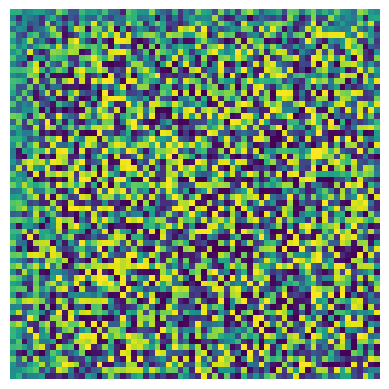

In [42]:
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import (Activation, BatchNormalization, Conv2D, Conv2DTranspose,
                          Dense, Dropout, Flatten, LeakyReLU, Reshape)
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from numpy import expand_dims, ones, vstack, zeros
from numpy.random import randn, randint
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow_datasets as tfds
import tensorflow_datasets as tfds
from tqdm import tqdm


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Define constants
ROOT = '.'
EPOCHS = 50
BATCH_SIZE = 128
IMG_SIZE = 64
NOISE_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)


# Load and preprocess image data
def load_and_preprocess_data():
    if not os.path.exists('all-dogs'):
        os.makedirs('all-dogs')
        !unzip -q '/content/drive/MyDrive/MSDS/all-dogs.zip' -d all-dogs

    if not os.path.exists('Annotation'):
        os.makedirs('Annotation')
        !unzip -q '/content/drive/MyDrive/MSDS/Annotation.zip' -d Annotation

    train = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=ROOT, target_size=(IMG_SIZE, IMG_SIZE), classes=['all-dogs'], batch_size=BATCH_SIZE)

    data_list = []
    batch_index = 0
    
    from tqdm import tqdm
    
    for batch_index in tqdm(range(50)):
        data = train.next()
        data_list.append(data[0])
    
    imgs = np.asarray(data_list)
    print(imgs.shape)
    imgs = imgs.reshape(6400, IMG_SIZE, IMG_SIZE, 3)
    imgs = (imgs-127.5)/127.5

    return imgs


# Define functions for building generator and discriminator models
def build_generator_model():
    model = Sequential()

    model.add(Dense(int(IMG_SIZE/8) * int(IMG_SIZE/8) * 512, use_bias=False, input_shape=(NOISE_DIM,), kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((int(IMG_SIZE/8), int(IMG_SIZE/8), 512)))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT ))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(3, activation='tanh', use_bias=False, kernel_initializer=WEIGHT_INIT))

    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


def build_discriminator_model():
    model = Sequential()

    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3], kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3)) 

    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


# Define GAN
def build_gan(discriminator, generator):
    model = Sequential()

    discriminator.trainable = False

    model.add(generator)
    model.add(discriminator)

    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model


# Get real images for training
def get_real_samples(n_samples, img_array):
    indexes = randint(0, img_array.shape[0], n_samples)
    reals = img_array[indexes]

    return reals


# Train models
def train_models(generator, discriminator, gan, img_array, epochs=EPOCHS, batch_size=BATCH_SIZE):
    for epoch in range(epochs):
        with tf.GradientTape() as gt, tf.GradientTape() as dt:
            # Generate with frozen generator
            noise = tf.random.normal(shape=(batch_size, NOISE_DIM))
            generated_img = generator(noise)

            # Mix generated and real inputs
            real_img = get_real_samples(batch_size, img_array)
            input_data = vstack((generated_img, real_img))
            output_data = vstack((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))

            # Train discriminator
            d_loss, _ = discriminator.train_on_batch(x=input_data, y=output_data)

            # Now train on the whole model
            noise = tf.random.normal(shape=(batch_size, NOISE_DIM))
            result = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, result)

            print(f'epoch: {epoch}, d_loss: {d_loss}, g_loss: {g_loss}')

    return generator


# Generate and save images
def generate_and_save_images(generator, n_samples=25):
    noise = tf.random.normal(shape=(n_samples, NOISE_DIM))
    x = generator.predict(noise)

    def save_plot(examples, n):
        # Plot images
        for i in range(n * n):
            # Define subplot
            plt.subplot(n, n, 1 + i)

            # Turn off axis
            plt.axis('off')

            # Plot raw pixel data
            plt.imshow(examples[i, :, :, 0] * 127.5 + 127.5)

        plt.show()

    save_plot(x, 1)


# Load and preprocess image data
img_array = load_and_preprocess_data()

# Build models
generator_model = build_generator_model()
discriminator_model = build_discriminator_model()
gan_model = build_gan(discriminator_model, generator_model)

# Train models
trained_generator_model = train_models(generator_model, discriminator_model, gan_model, img_array)

# Save generator model
trained_generator_model.save('/g_model')

# Generate and save images
generated_images = generate_and_save_images(trained_generator_model) 
